<a href="https://colab.research.google.com/github/compressed-sensing/algorithms/blob/feature%2Fnotebooks/notebooks/1D_TVD_Ivan_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementation of 1D TVD using Maximization and Minimization algorithm and Iterative clipping algorithm. [Reference](https://eeweb.engineering.nyu.edu/iselesni/lecture_notes/TVDmm/TVD_software/html/Example1.html)

In [ ]:
%%shell
wget https://eeweb.engineering.nyu.edu/iselesni/lecture_notes/TVDmm/TVD_software/blocks.txt
wget https://eeweb.engineering.nyu.edu/iselesni/lecture_notes/TVDmm/TVD_software/blocks_noisy.txt

--2023-04-06 12:54:22--  https://eeweb.engineering.nyu.edu/iselesni/lecture_notes/TVDmm/TVD_software/blocks.txt
Resolving eeweb.engineering.nyu.edu (eeweb.engineering.nyu.edu)... 128.238.64.104
Connecting to eeweb.engineering.nyu.edu (eeweb.engineering.nyu.edu)|128.238.64.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4352 (4.2K) [text/plain]
Saving to: ‘blocks.txt’

blocks.txt          100%[===================>]   4.25K  --.-KB/s    in 0s      

2023-04-06 12:54:22 (47.8 MB/s) - ‘blocks.txt’ saved [4352/4352]

--2023-04-06 12:54:22--  https://eeweb.engineering.nyu.edu/iselesni/lecture_notes/TVDmm/TVD_software/blocks_noisy.txt
Resolving eeweb.engineering.nyu.edu (eeweb.engineering.nyu.edu)... 128.238.64.104
Connecting to eeweb.engineering.nyu.edu (eeweb.engineering.nyu.edu)|128.238.64.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4352 (4.2K) [text/plain]
Saving to: ‘blocks_noisy.txt’

blocks_noisy.txt    100%[==============

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, spdiags, diags, csc_matrix, eye
from scipy.sparse.linalg import spsolve
from scipy.linalg import solve
from scipy.fftpack import fft, ifft
import time

In [ ]:
s = np.loadtxt('blocks.txt')
y = np.loadtxt('blocks_noisy.txt')

In [ ]:
N = 256;                        # N : signal length
sigma = 0.5;                    # sigma : standard deviation of noise

Text(0.5, 1.0, 'noisy signal')

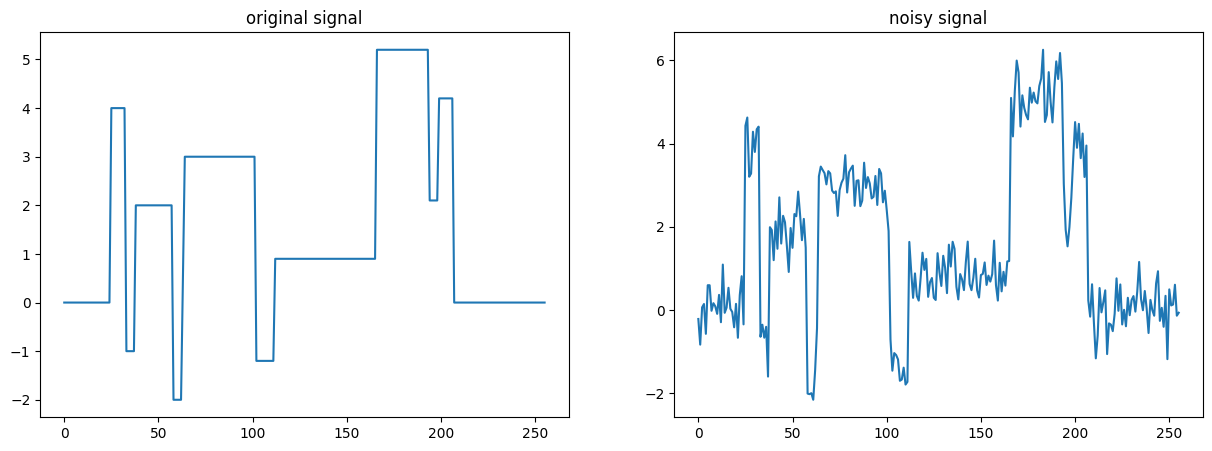

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(s)
axs[0].set_title("original signal")
axs[1].plot(y)
axs[1].set_title("noisy signal")

# Using linear systems

In [ ]:
def tvd_mm(y, lam, Nit):
    start = time.time()
    # Cost function history
    cost = np.zeros(Nit)

    # Signal length
    N = y.shape[0]

    # Create sparse difference matrix
    I = np.eye(N)
    D = spdiags(np.vstack((np.ones((1,N)), -1*np.ones((1,N)))), [0,1], N-1, N)
    DDT = D @ D.T

    # Initialization
    x = y.copy()
    Dx = D @ x
    Dy = D @ y

    for k in range(Nit):
        # Compute banded matrix F
        F = csc_matrix(diags(np.abs(Dx).flatten()/lam, 0)) + DDT
        # Solve linear system to get updated signal x
        x = y - D.T @ spsolve(F, Dy)

        # Update variables
        Dx = D @ x
        cost[k] = 0.5 * np.sum(np.abs(x - y)**2) + lam * np.sum(np.abs(Dx))
    
    end = time.time()

    return x.flatten(), cost, end-start


Time taken = 0.41242027282714844


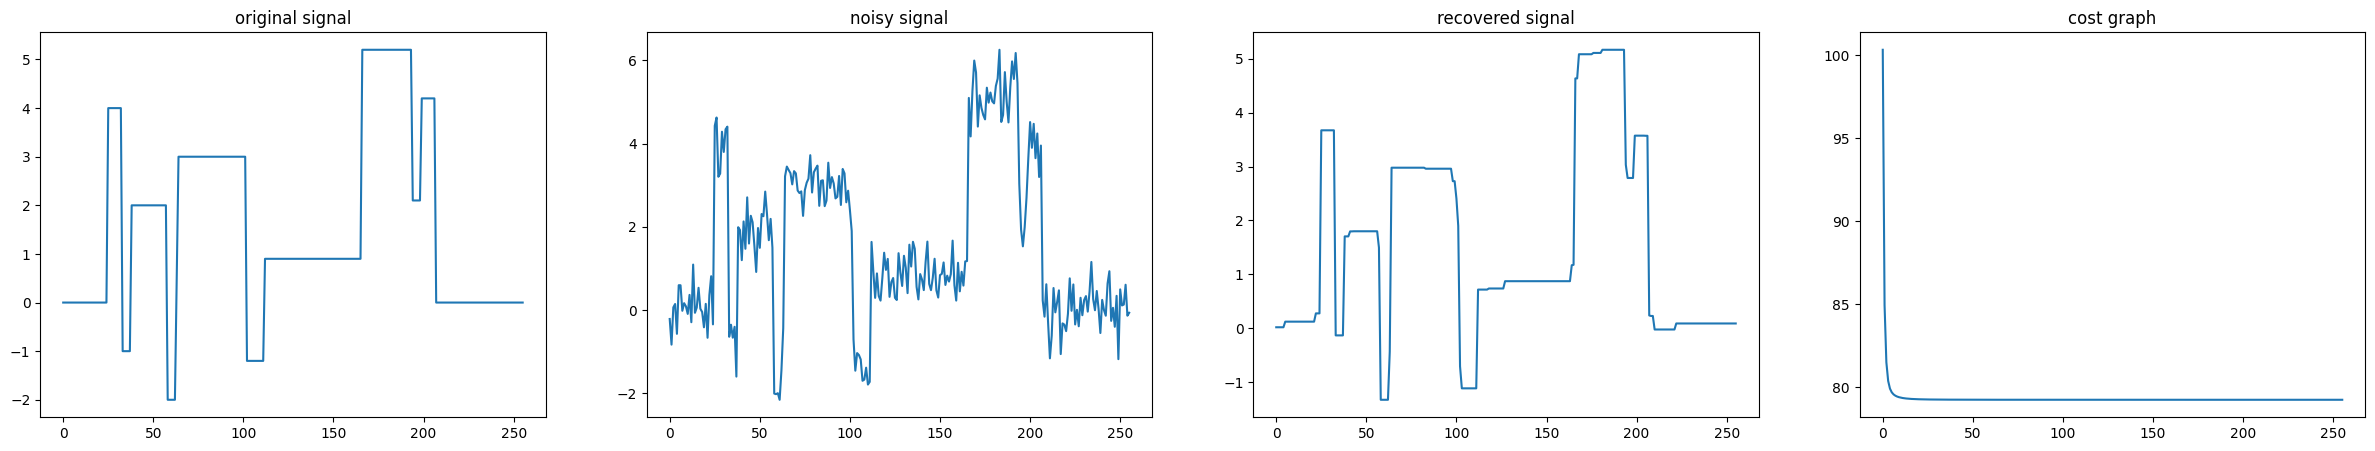

In [ ]:
lam = 1.5
max_iter = 256
x_mm, cost_mm, time_taken = tvd_mm(y, lam, max_iter)
fig, axs = plt.subplots(1, 4, figsize=(30,5))
axs[0].plot(s)
axs[0].set_title("original signal")
axs[1].plot(y)
axs[1].set_title("noisy signal")
axs[2].plot(x_mm)
axs[2].set_title("recovered signal")
axs[3].plot(cost_mm)
axs[3].set_title("cost graph")
print(f"Time taken = {time_taken}")

In [ ]:
def tvd_ic(y, lam, Nit):
    start = time.time()
    y = y.reshape((1, -1))  # row vector
    J = np.zeros(Nit)  # objective function
    N = y.shape[1]
    z = np.zeros((1, N-1))
    alpha = 3
    T = lam / 2
    x = y.copy()
    for k in range(Nit):
        inter = np.concatenate((-z[:,0], -np.diff(z.flatten()), z[:,-1]))
        
        x = y - inter  # y - D' z

        J[k] = 0.5*np.sum(np.abs(x - y) ** 2) + lam * np.sum(np.abs(np.diff(x)))

        z = z + 1 / alpha * np.diff(x)  # z + 1/alpha D z

        z = np.clip(z, -T, T)  # clip(z,T)

    end = time.time()
    return x.flatten(), J, end-start


Time taken = 0.126143217086792


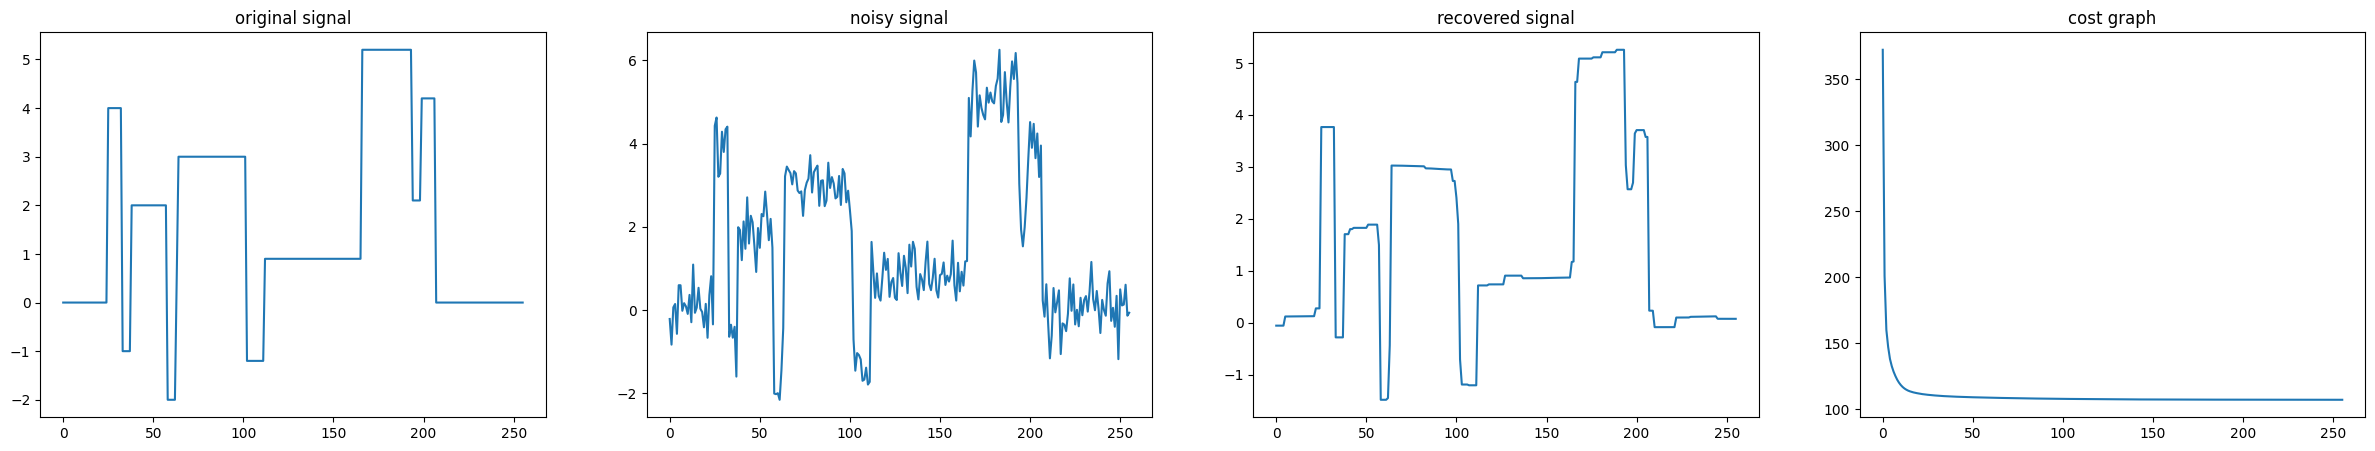

In [ ]:
max_iter = 256
x_ic, cost_ic, time_taken = tvd_ic(y, 1.5*lam, max_iter)
fig, axs = plt.subplots(1, 4, figsize=(30,5))
axs[0].plot(s)
axs[0].set_title("original signal")
axs[1].plot(y)
axs[1].set_title("noisy signal")
axs[2].plot(x_ic)
axs[2].set_title("recovered signal")
axs[3].plot(cost_ic)
axs[3].set_title("cost graph")
print(f"Time taken = {time_taken}")

In [ ]:
soft_thresh = lambda v, t: np.maximum(np.abs(v)-t, 0.)*np.sign(v)

In [ ]:
# def tvd_admm(y, lam, Nit, mu1=1, mu2=1):
#     start = time.time()
#     cost = np.zeros(Nit)  # objective function
#     print(y.shape)
#     # Signal length
#     N = y.shape[0]
#     T = 0.5 * lam / mu2

#     e = np.ones(N - 1)
#     Dmtx = spdiags([e, -e], [0, 1], N - 1, N)  # sparse matrix
#     F = mu1 * eye(N) + mu2 * (Dmtx.T @ Dmtx)  # sparse matrix

#     D = lambda x: np.diff(x, axis=0)  # D
#     DT = lambda x: np.concatenate(([-x[0,:]], -np.diff(x, axis=0), [x[-1,:]]))  # D'

#     # initializations
#     # u1 = y.copy()
#     # d1 = np.zeros((N, 1))
#     # u2 = np.zeros((N-1, 1))
#     # d2 = np.zeros((N-1, 1))
#     d = np.zeros((N-1, 1))
#     x = np.zeros((N, 1))

#     for k in range(Nit):
#       u = soft_thresh(D(x) + d, T)
#       x = spsolve(F, (y + mu2*DT(u-d)))
#       d = d - (u - D(x))
#       cost[k] = np.sum(np.abs(x - y) ** 2) + lam * np.sum(np.abs(D(x)))

#     # for k in range(Nit):
#     #     v1 = (y - d1 + mu1 * x) / (1 + mu1)
#     #     v2 = soft_thresh(D(x)+d2, T) - d2
#     #     x = spsolve(F, mu1 * v1 + mu2 * DT(v2))  # sparse system solve
#     #     d1 = x - v1
#     #     d2 = D(x) - v2
#     #     cost[k] = np.sum(np.abs(x - y) ** 2) + lam * np.sum(np.abs(D(x)))

#     # for k in range(Nit):
#     #   x = spsolve(F, (mu1*(u1-d1) + mu2*DT(u2-d2)))
#     #   u1 = (y + mu1*(x+d1)) / (1 + mu1)
#     #   u2 = soft_thresh(D(x)+d2, T)
#     #   d1 = d1 - (u1-x)
#     #   d2 = d2 - (u2-D(x))
#     #   cost[k] = np.sum(np.abs(x - y) ** 2) + lam * np.sum(np.abs(D(x)))
#     end = time.time()
#     return x.flatten(), cost, end-start

In [ ]:
# ver3
def tvd_admm(y, lam, Nit, mu1=1, mu2=1):
    start = time.time()
    y = np.expand_dims(y,axis=1)
    cost = np.zeros(Nit)  # objective function
    # Signal length
    N = y.shape[0]
    T = 0.5 * lam / mu2

    e = np.ones(N - 1)
    Dmtx = spdiags([e, -e], [0, 1], N - 1, N)  # sparse matrix
    F = mu1 * eye(N) + mu2 * (Dmtx.T @ Dmtx)  # sparse matrix
    print(F.shape)

    D = lambda x: np.diff(x, axis=0)  # D
    DT = lambda x: np.concatenate((-x[:1,], -np.diff(x, axis=0), x[-1:,]))  # D'

    # initializations
    # u1 = y.copy()
    d1 = np.zeros((N, N))
    d2 = np.zeros((N-1, 1))
    x = np.zeros((N, 1))
    for k in range(Nit):
      v1 = (y - d1 + mu1 * x) / (1 + mu1)
      v2 = soft_thresh(D(x)+d2, T) - d2
      x = spsolve(F, mu1 * v1 + mu2 * DT(v2))  # sparse system solve
      d1 = x - v1
      d2 = D(x) - v2
      # x = np.expand_dims(x,axis=1)
      cost[k] = np.sum(np.abs(x - y) ** 2) + lam * np.sum(np.abs(D(x)))


    end = time.time()
    return x.flatten(), cost, end-start

(256, 256)
0 (256, 256) (255, 1) (256, 1) (256, 256) (255, 1) (256, 1)
1 (256, 256) (255, 256) (256, 256) (256, 256) (255, 256) (256, 256)
2 (256, 256) (255, 256) (256, 256) (256, 256) (255, 256) (256, 256)
3 (256, 256) (255, 256) (256, 256) (256, 256) (255, 256) (256, 256)
4 (256, 256) (255, 256) (256, 256) (256, 256) (255, 256) (256, 256)
5 (256, 256) (255, 256) (256, 256) (256, 256) (255, 256) (256, 256)
6 (256, 256) (255, 256) (256, 256) (256, 256) (255, 256) (256, 256)
7 (256, 256) (255, 256) (256, 256) (256, 256) (255, 256) (256, 256)
8 (256, 256) (255, 256) (256, 256) (256, 256) (255, 256) (256, 256)
9 (256, 256) (255, 256) (256, 256) (256, 256) (255, 256) (256, 256)
10 (256, 256) (255, 256) (256, 256) (256, 256) (255, 256) (256, 256)
11 (256, 256) (255, 256) (256, 256) (256, 256) (255, 256) (256, 256)
12 (256, 256) (255, 256) (256, 256) (256, 256) (255, 256) (256, 256)
13 (256, 256) (255, 256) (256, 256) (256, 256) (255, 256) (256, 256)
14 (256, 256) (255, 256) (256, 256) (256,

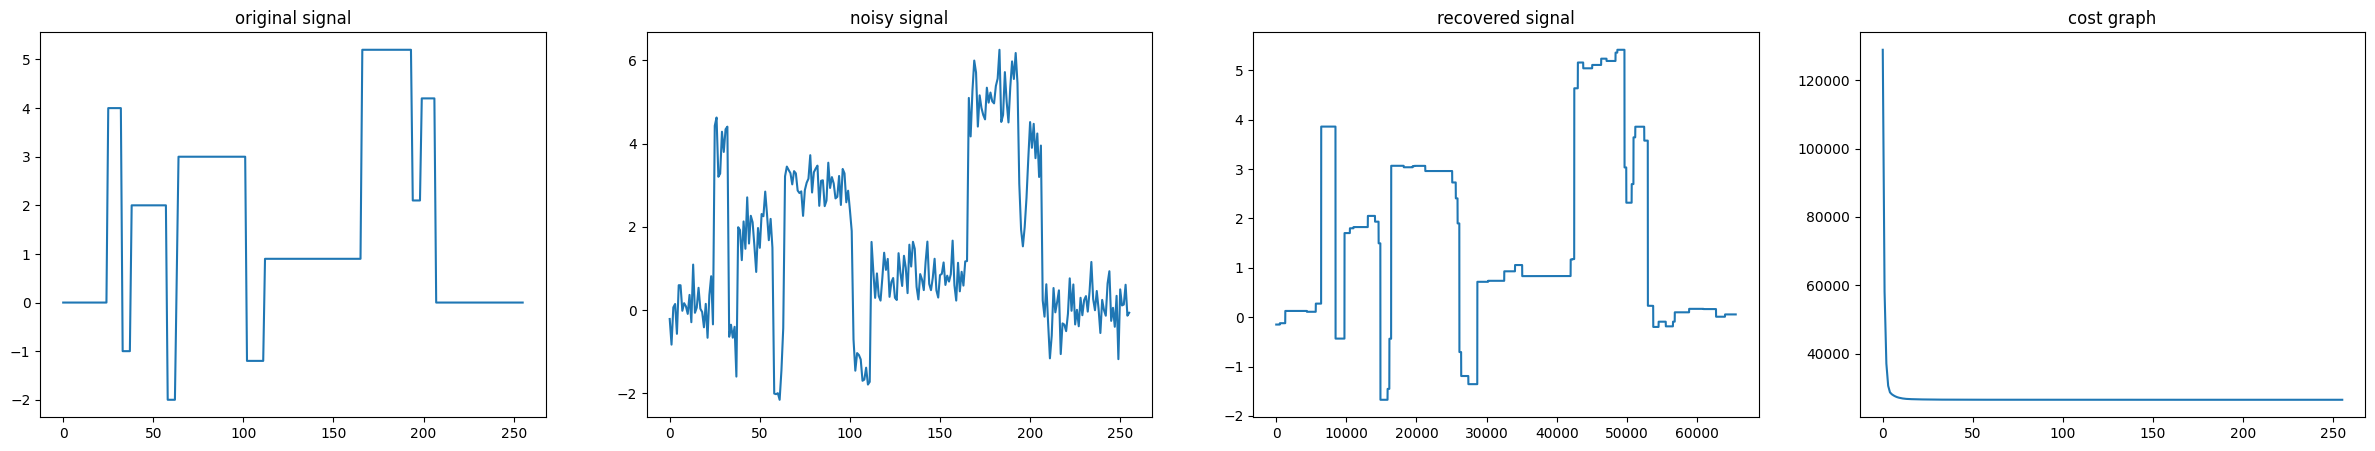

In [ ]:
max_iter = 256
x_admm, cost_admm, time_taken = tvd_admm(y, lam, max_iter)
fig, axs = plt.subplots(1, 4, figsize=(30,5))
axs[0].plot(s)
axs[0].set_title("original signal")
axs[1].plot(y)
axs[1].set_title("noisy signal")
axs[2].plot(x_admm)
axs[2].set_title("recovered signal")
axs[3].plot(cost_admm)
axs[3].set_title("cost graph")
print(f"Time taken = {time_taken}")

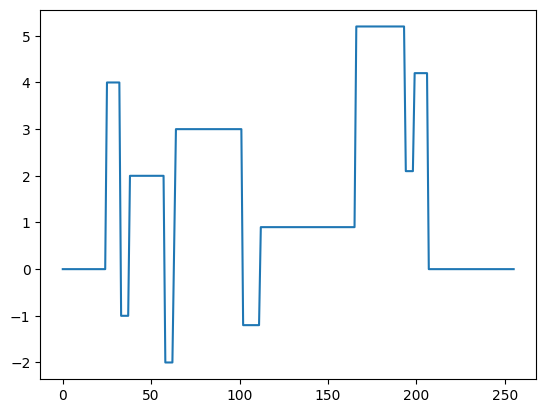

In [ ]:
plt.plot(s)
# plt.title("original_signal")
# plt.axis('off')

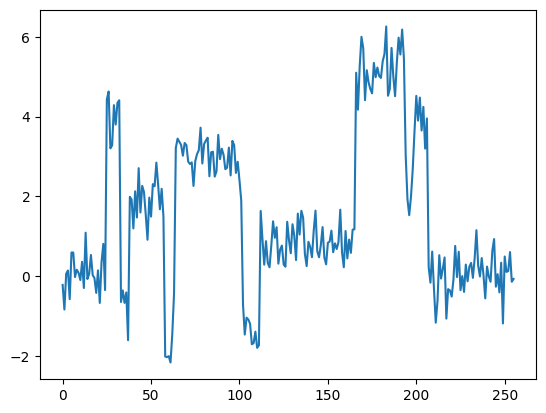

In [ ]:
plt.plot(y)
# plt.title("noisy_signal")
# plt.axis('off')

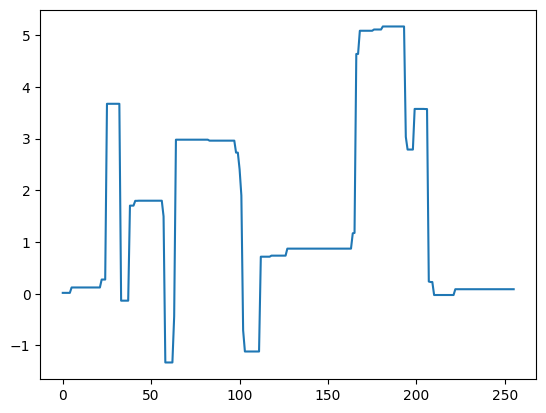

In [ ]:
plt.plot(x_mm)
# plt.title("MM algorithm")
# plt.axis('off')

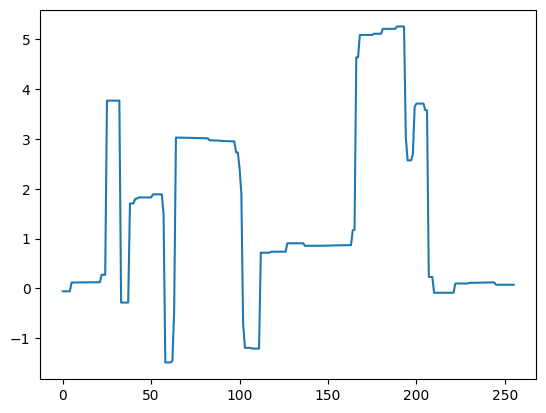

In [ ]:
plt.plot(x_ic)
# plt.axis('off')

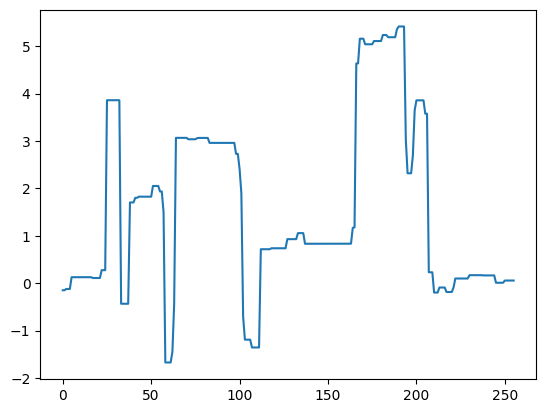

In [ ]:

plt.plot(x_admm[::N])
# plt.axis('off')